In [18]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../../../Revenue.csv')

### 1) EDA

In [3]:
before = df[(df['session_start_dt'].str.contains("2019")) 
                   | (df['session_start_dt'].str.contains("2020-01")) 
                   | (df['session_start_dt'].str.contains("2020-02"))]
after = df[(~df['session_start_dt'].str.contains("2019")) 
                   & (~df['session_start_dt'].str.contains("2020-01")) 
                   & (~df['session_start_dt'].str.contains("2020-02"))]

In [4]:
last12 = df[(df['session_start_dt'].str.contains("2019"))]
this1 = df[(df['session_start_dt'].str.contains("2020-01"))]
this2 = df[(df['session_start_dt'].str.contains("2020-02"))]
this3 = df[(df['session_start_dt'].str.contains("2020-03"))]
this4 = df[(df['session_start_dt'].str.contains("2020-04"))]
this5 = df[(df['session_start_dt'].str.contains("2020-05"))]
this6 = df[(df['session_start_dt'].str.contains("2020-06"))]
this7 = df[(df['session_start_dt'].str.contains("2020-07"))]
this8 = df[(df['session_start_dt'].str.contains("2020-08"))]
this9 = df[(df['session_start_dt'].str.contains("2020-09"))]
this10 = df[(df['session_start_dt'].str.contains("2020-10"))]
this11 = df[(df['session_start_dt'].str.contains("2020-11"))]


([<matplotlib.axis.XTick at 0x7f807ca51e10>,
 <a list of 12 Text xticklabel objects>)

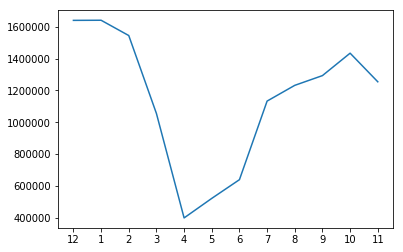

In [5]:
plt.plot([len(last12), len(this1), len(this2), len(this3), len(this4), len(this5), len(this6), len(this7), len(this8), len(this9), len(this10), len(this11)])
plt.xticks(np.arange(12), (12,1,2,3,4,5,6,7,8,9,10,11))

### 2) Demand: Time slot (per half an hour) & Covid stage

In [6]:
def stage(dt):
    if dt < datetime(2020, 3, 15): 
        return 0 # before
    elif (dt >= datetime(2020, 3, 15)) & (dt < datetime(2020,5, 17)):
        return 1 # shutdown
    elif (dt >= datetime(2020, 5, 17)) & (dt < datetime(2020,7, 17)):
        return 2 # reopen 
    elif (dt >= datetime(2020, 7, 17)) & (dt < datetime(2020, 9, 30)):
        return 3 # closed_due_to_state_re
    elif (dt >= datetime(2020, 9, 30)) & (dt < datetime(2020, 10, 20)):
        return 4 # orange
    elif (dt >= datetime(2020, 10, 20)) & (dt < datetime(2020, 11, 13)):
        return 5 # yellow
    elif dt >= datetime(2020, 11, 13):
        return 6 # rollback

In [7]:
df['dt'] = df['session_start_dt'].apply(lambda x: datetime.strptime(x[:19], '%Y-%m-%dT%H:%M:%S'))
df['date'] = df['dt'].dt.date
df['slot'] = df['dt'].apply(lambda x: int(x.hour) * 2 + (1 if int(x.minute) < 30 else 2) - 1)
df['stage'] = df['dt'].apply(lambda x: stage(x))

In [8]:
df.describe()

,index,gross_paid_amt,BLOCKFACE_ID,slot,stage
count,1.379242e+07,1.379242e+07,1.379242e+07,1.379242e+07,1.379242e+07
mean,6.896209e+06,2.038540e+00,4.718568e+05,2.568958e+01,1.926556e+00
std,3.981529e+06,2.708955e+00,1.812418e+05,5.536974e+00,1.931886e+00
min,0.000000e+00,0.000000e+00,1.020210e+05,0.000000e+00,0.000000e+00
25%,3.448104e+06,4.900000e-01,3.521310e+05,2.100000e+01,0.000000e+00
50%,6.896209e+06,1.000000e+00,4.701110e+05,2.600000e+01,2.000000e+00
75%,1.034431e+07,2.750000e+00,6.061510e+05,3.000000e+01,3.000000e+00
max,1.379242e+07,7.150000e+01,8.780020e+05,4.700000e+01,6.000000e+00


In [9]:
for_demand_date = df.groupby(['BLOCKFACE_ID','stage','date','slot']).count()['gross_paid_amt'].reset_index()
for_demand_date['count'] = for_demand_date['gross_paid_amt']

In [11]:
df_block = pd.read_csv('../../data/Meters/Meter_block.csv')

In [30]:
d = [datetime(2019, 12, 1)]
for i in range(365):
    d.append(d[-1] + timedelta(days=1))

In [37]:
b = []
dt = []
sl = []

for block_ in list(df_block['BLOCKFACE_ID'].unique()):
    for date_ in d:
        for slot_ in range(48):
            b.append(block_)
            dt.append(date_)
            sl.append(slot_)

In [40]:
fakedata = {'BLOCKFACE_ID':b,
            'date': dt,
            'slot':sl,
            'count':[0]*366*48*len(df_block['BLOCKFACE_ID'].unique())}
fakedf = pd.DataFrame(fakedata)
fakedf['stage'] = fakedf['date'].apply(lambda x: stage(x))

In [42]:
for_demand = pd.concat([fakedf,for_demand_date[['BLOCKFACE_ID','date','slot', 'count', 'stage']]])
for_demand = for_demand.drop_duplicates(subset=['BLOCKFACE_ID','date','slot'], keep='last')

In [45]:
for_demand_agg = pd.DataFrame()
for_demand_agg['mean'] = for_demand.groupby(['BLOCKFACE_ID', 'stage', 'slot']).mean()['count']
for_demand_agg['std'] = for_demand.groupby(['BLOCKFACE_ID', 'stage', 'slot']).std()['count']
for_demand_agg['std'] = for_demand_agg['std'].clip(lower=0.01)

In [ ]:
for_demand_agg = for_demand_agg.reset_index().sort_values(['BLOCKFACE_ID','stage','slot'])

In [ ]:
for_demand_agg.describe()

In [15]:
for_demand_agg.to_csv('../../data/demand.csv', index=None)

### Time to park

In [18]:
df['dt_e'] = df['session_end_dt'].apply(lambda x: datetime.strptime(x[:19], '%Y-%m-%dT%H:%M:%S'))

In [29]:
df['time_diff'] = df['dt_e'] - df['dt']

In [39]:
df.groupby(['BLOCKFACE_ID', 'stage', 'slot'])['time_diff'].agg(lambda x: x.mean())

BLOCKFACE_ID  stage                   slot
102021        before                  8.5           00:49:51
                                      9.0    01:01:34.611111
                                      9.5    00:45:54.076923
                                      10.0   00:58:48.652173
                                      10.5   00:49:31.676470
                                      11.0   00:51:24.444444
                                      11.5   00:43:17.095238
                                      12.0   00:49:44.125000
                                      12.5   00:51:08.731707
                                      13.0   01:01:05.419354
                                      13.5   00:56:19.320000
                                      14.0   00:53:38.200000
                                      14.5   00:34:52.954545
                                      15.0   00:46:58.484848
                                      15.5   01:07:30.518518
                                      16.0

### Naive time to park model

In [41]:
df.groupby(['BLOCKFACE_ID'])['time_diff'].agg(lambda x: [x.mean(), x.std()])

BLOCKFACE_ID
102021    [0 days 00:48:53.848045, 0 days 00:47:20.988257]
102031    [0 days 01:02:50.036098, 0 days 01:06:23.517211]
102032    [0 days 01:02:34.050225, 0 days 01:03:15.480959]
102041    [0 days 00:58:59.733431, 0 days 01:02:01.547902]
102042    [0 days 00:50:32.069705, 0 days 00:54:08.961816]
103021    [0 days 00:44:51.315463, 0 days 00:44:57.402401]
103022    [0 days 00:21:04.939189, 0 days 00:19:33.194254]
103031    [0 days 00:41:28.523105, 0 days 00:43:04.923051]
103032    [0 days 00:48:20.317450, 0 days 00:44:20.698372]
103132    [0 days 01:18:50.346277, 0 days 01:05:52.415737]
104021    [0 days 00:54:27.858660, 0 days 00:46:47.437402]
104022    [0 days 00:55:19.347713, 0 days 00:49:15.649553]
104031    [0 days 00:57:54.170716, 0 days 01:01:06.798987]
104032    [0 days 00:57:27.954680, 0 days 00:54:58.310158]
104033    [0 days 01:08:09.461201, 0 days 01:05:13.705866]
104034    [0 days 01:08:35.542575, 0 days 01:11:02.796144]
104041    [0 days 00:56:26.328429, 0 days 0